# Sentiment analysis

Here is the code of how we performed sentiment analysis to our dataset. The csv files of the dataset that we used are in the ini_csv.rar. The final version of them are in the f_csv.rar

## Libraries 

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections

# for sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# To determine the language of text
import langid

# remove special character
import re

# for plots
plt.style.use('ggplot')
print('allgood')

allgood


## HPC

As mentioned in the paper, we used hpc in order to clean the data and perform sentiment analysis. The steps were:
1. Remove Nan values
2. Language classification in order to remove the non english text
3. Remove special characters
4. Perform sentiment analysis

This was performed 2 times. One time for the listings.csv and one more for the reviews.csv. Below it the scripts with the shell script.

In [52]:
# shell of listings.csv

'''Job <My_Application> was submitted from host <n-62-27-23> by user <geofr> in cluster <dcc> at Fri Nov 22 20:28:48 2024 Job was executed on host(s) <4*n-62-28-33>, in queue <hpc>, as user <geofr> in cluster <dcc> at Fri Nov 22 20:28:49 2024 </zhome/9b/1/213524> was used as the home directory.
</zhome/9b/1/213524/tes> was used as the working directory.
Started at Fri Nov 22 20:28:49 2024
Terminated at Fri Nov 22 22:32:36 2024
Results reported at Fri Nov 22 22:32:36 2024

Your job looked like:

------------------------------------------------------------
# LSBATCH: User input
#!/bin/sh
### General options
### -- specify queue --
#BSUB -q hpc
### -- set the job Name --
#BSUB -J My_Application
### -- ask for number of cores (default: 1) -- #BSUB -n 4 ### -- specify that the cores must be on the same host -- #BSUB -R "span[hosts=1]"
### BSUB -R "span[hosts=1]" -or- BSUB -R "span[ptile=2]" then kill in 10GB ### -- specify that we need 4GB of memory per core/slot -- #BSUB -R "rusage[mem=4GB]"
### -- specify that we want the job to get killed if it exceeds 5 GB per core/slot -- #BSUB -M 5GB ### -- set walltime limit: hh:mm -- #BSUB -W 24:00 ### -- set the email address -- # please uncomment the following line and put in your e-mail address, # if you want to receive e-mail notifications on a non-default address BSUB -u geofr@dtu.dk ### -- send notification at start -- #BSUB -B ### -- send notification at completion -- #BSUB -N ### -- Specify the output and error file. %J is the job-id -- ### -- -o and -e mean append, -oo and -eo mean overwrite -- #BSUB -o Output_%J.out #BSUB -e Output_%J.err 

source /zhome/9b/1/213524/tes/anenv/bin/activate
# here follow the commands you want to execute with input.in as the input file
python3 gena.py
###gena.py < NYlistings.csv > results.txt
------------------------------------------------------------

Successfully completed.

Resource usage summary:

    CPU time :                                   7426.08 sec.
    Max Memory :                                 618 MB
    Average Memory :                             578.13 MB
    Total Requested Memory :                     16384.00 MB
    Delta Memory :                               15766.00 MB
    Max Swap :                                   -
    Max Processes :                              4
    Max Threads :                                9
    Run time :                                   7532 sec.
    Turnaround time :                            7428 sec.'''



'Job <My_Application> was submitted from host <n-62-27-23> by user <geofr> in cluster <dcc> at Fri Nov 22 20:28:48 2024 Job was executed on host(s) <4*n-62-28-33>, in queue <hpc>, as user <geofr> in cluster <dcc> at Fri Nov 22 20:28:49 2024 </zhome/9b/1/213524> was used as the home directory.\n</zhome/9b/1/213524/tes> was used as the working directory.\nStarted at Fri Nov 22 20:28:49 2024\nTerminated at Fri Nov 22 22:32:36 2024\nResults reported at Fri Nov 22 22:32:36 2024\n\nYour job looked like:\n\n------------------------------------------------------------\n# LSBATCH: User input\n#!/bin/sh\n### General options\n### -- specify queue --\n#BSUB -q hpc\n### -- set the job Name --\n#BSUB -J My_Application\n### -- ask for number of cores (default: 1) -- #BSUB -n 4 ### -- specify that the cores must be on the same host -- #BSUB -R "span[hosts=1]"\n### BSUB -R "span[hosts=1]" -or- BSUB -R "span[ptile=2]" then kill in 10GB ### -- specify that we need 4GB of memory per core/slot -- #BSUB -R 

In [ ]:
# listings.csv script for hpc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# for language classification
import langid

# remove special character
import re

plt.style.use('ggplot')
print('allgood')

# rEAD DATA
df=pd.read_csv('listings.csv')

# in case you want to run the code and see how it performs 
df=df.head(10)

# for sentiment analysis install model
MODEL=F"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

# this is in order to remove special characters
pattern = r'[^A-Za-z0-9 ]'

# sentiment analysis function 
# function returns 4 scores of sentiment analysis
def senti(t):
    ##
    # t:str , the text we want to apply sentiment to
    # return: list of 4 scores from the sentiment analysis
    ##

    # call the model
    encoded_text=tokenizer(t,return_tensors='pt')
    output=model(**encoded_text)
    # scores of sentiment analysis
    scores=output[0][0].detach().numpy()
    # apply softmax to scores
    scores=softmax(scores)
    
    # scores consist the negative,neutral and positive score all from [0,1] and the sum equal to one because of softmax
    scores_list=[scores[0],scores[1],scores[2]]

    # Function returns 4 scores 
    # negative, neutral, positive, integer of sentiment with 0 being negative, 1 being neutral, 2 being positive sentiment
    return [scores[0],scores[1],scores[2], scores_list.index(max(scores_list))]
    

# cleaning function

def supadupaclean(panda,n,cols):
    ##
    # panda:dataset
    # n:int , the number of observations we want to clean
    # cols: list, list of strings that contain the name of columns we want to analyze
    # return: 2 pd, the one that is after we dropped all nan and the other with the sentiment scores
    ##

    # head hese is called in order to execute test runs in HPC with small number of data 
    k=panda.head(n)
    # select columns
    k=k[cols]
    # drop rows that contain nan in a all column
    k=k.dropna()
    print(k.shape)

    # just a quicksave of our dataset to see what observations were dropped
    #k.to_csv('NYclean.csv', index=False)

    # List of the titles of our final columns
    # contains the id, the text in name and description with their length
    # and next to them are the respective results from the sentiment
    # review_scores_rating is another score that we took from the listing
    fcol=['id',
          'name','name_len','name_neg_s','name_neu_s','name_pos_s','name_sent',
          'desc','desc_len','desc_neg_s','desc_neu_s','desc_pos_s','desc_sent', 
          'review_scores_rating', 'review_scores_rating_int']
    
    a=[fcol]
    for i in range(len(k)):
        b=0
        # take the text values from each row
        for j in [k.iloc[i][1],k.iloc[i][2]]:
            # language classification
            landet=langid.classify(j)
            # remove non english text
            if landet[0]!='en' and landet[1]>=0.7:
                b=1
        if b==0:
            row=list(k.iloc[i])
            # remove special characters
            mod=[row[0],re.sub(pattern, "", row[1]),re.sub(pattern, "", row[2]),float(row[3]),int(float(row[3]))]

            mod=[mod[0],mod[1],len(mod[1])]+senti(mod[1])+[mod[2],len(mod[2])]+senti(mod[2])+[mod[3],mod[4]]
            
            a.append(mod)
    transdf = pd.DataFrame(a)
    transdf.to_csv('NYtrans.csv',index=False)
        
    print(transdf.shape)
    return k,transdf


allcol=['id','name', 'description','review_scores_rating']
# len(df)
cleandf,transdf=supadupaclean(df,len(df),allcol)
print(cleandf.shape)
print(cleandf.head())

allgood
(2, 4)


C:\Users\georg\AppData\Local\Temp\ipykernel_22212\4096336447.py:92: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j in [k.iloc[i][1],k.iloc[i][2]]:


(3, 15)
(2, 4)
                   id                                          name  \
1  572612125615500056  Room by Sunny & Bay! Sunset Park & Bay Ridge   
8            13234457             Cozy Clinton Hill Crib On Classon   

                                         description  review_scores_rating  
1  Cozy room in a charming Sunset Park apartment....                  4.83  
8  My place is close to Barclays Center, Alice's ...                  4.00  


In [54]:
# shell of review.csv

'''Job <My_Application> was submitted from host <n-62-29-7> by user <geofr> in cluster <dcc> at Sun Nov 24 17:46:23 2024 Job was executed on host(s) <4*n-62-28-29>, in queue <hpc>, as user <geofr> in cluster <dcc> at Sun Nov 24 17:46:23 2024 </zhome/9b/1/213524> was used as the home directory.
</zhome/9b/1/213524/tes> was used as the working directory.
Started at Sun Nov 24 17:46:23 2024
Terminated at Mon Nov 25 17:46:49 2024
Results reported at Mon Nov 25 17:46:49 2024

Your job looked like:

------------------------------------------------------------
# LSBATCH: User input
#!/bin/sh
### General options
### -- specify queue --
#BSUB -q hpc
### -- set the job Name --
#BSUB -J My_Application
### -- ask for number of cores (default: 1) -- #BSUB -n 4 ### -- specify that the cores must be on the same host -- #BSUB -R "span[hosts=1]"
### BSUB -R "span[hosts=1]" -or- BSUB -R "span[ptile=2]" then kill in 10GB ### -- specify that we need 4GB of memory per core/slot -- #BSUB -R "rusage[mem=4GB]"
### -- specify that we want the job to get killed if it exceeds 5 GB per core/slot -- #BSUB -M 5GB ### -- set walltime limit: hh:mm -- #BSUB -W 24:00 ### -- set the email address -- # please uncomment the following line and put in your e-mail address, # if you want to receive e-mail notifications on a non-default address BSUB -u geofr@dtu.dk ### -- send notification at start -- #BSUB -B ### -- send notification at completion -- #BSUB -N ### -- Specify the output and error file. %J is the job-id -- ### -- -o and -e mean append, -oo and -eo mean overwrite -- #BSUB -o Output_%J.out #BSUB -e Output_%J.err 

module load python3/3.10
source /zhome/9b/1/213524/tes/anenv/bin/activate
# here follow the commands you want to execute with input.in as the input file
python3 gery.py
###gena.py < NYlistings.csv > results.txt
------------------------------------------------------------

TERM_RUNLIMIT: job killed after reaching LSF run time limit.
Exited with exit code 140.

Resource usage summary:

    CPU time :                                   75603.00 sec.
    Max Memory :                                 1365 MB
    Average Memory :                             1183.65 MB
    Total Requested Memory :                     16384.00 MB
    Delta Memory :                               15019.00 MB
    Max Swap :                                   -
    Max Processes :                              4
    Max Threads :                                9
    Run time :                                   86426 sec.
    Turnaround time :                            86426 sec.
'''

'Job <My_Application> was submitted from host <n-62-29-7> by user <geofr> in cluster <dcc> at Sun Nov 24 17:46:23 2024 Job was executed on host(s) <4*n-62-28-29>, in queue <hpc>, as user <geofr> in cluster <dcc> at Sun Nov 24 17:46:23 2024 </zhome/9b/1/213524> was used as the home directory.\n</zhome/9b/1/213524/tes> was used as the working directory.\nStarted at Sun Nov 24 17:46:23 2024\nTerminated at Mon Nov 25 17:46:49 2024\nResults reported at Mon Nov 25 17:46:49 2024\n\nYour job looked like:\n\n------------------------------------------------------------\n# LSBATCH: User input\n#!/bin/sh\n### General options\n### -- specify queue --\n#BSUB -q hpc\n### -- set the job Name --\n#BSUB -J My_Application\n### -- ask for number of cores (default: 1) -- #BSUB -n 4 ### -- specify that the cores must be on the same host -- #BSUB -R "span[hosts=1]"\n### BSUB -R "span[hosts=1]" -or- BSUB -R "span[ptile=2]" then kill in 10GB ### -- specify that we need 4GB of memory per core/slot -- #BSUB -R "

In [ ]:
# reviews.csv script for hpc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for sentiment analysis
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

# language classification
import langid

# remove special characyer
import re

plt.style.use('ggplot')
print('allgood')

# rEAD DATA
df=pd.read_csv('reviews.csv')

# in case you want to run the code and see how it performs 
df=df.head(10)

# for sentiment analysis install model
MODEL=F"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer=AutoTokenizer.from_pretrained(MODEL)
model=AutoModelForSequenceClassification.from_pretrained(MODEL)

# to remove special characters
pattern = r'[^A-Za-z0-9 ]'

def senti(t):
    ##
    # t:str , the text we want to apply sentiment to
    # return: list of 4 scores from the sentiment analysis
    ##

    # in order to avoid errors because of long text
    encoded_text = tokenizer(t, padding=True, max_length=512, truncation=True, return_tensors="pt")
    output=model(**encoded_text)
    scores=output[0][0].detach().numpy()
    scores=softmax(scores)
    
    scores_list=[scores[0],scores[1],scores[2]]
    # negative, neutral, positive, integer of sentiment with 0 neg, 1 neu, 2 pos
    return [scores[0],scores[1],scores[2], scores_list.index(max(scores_list))]
    

def supadupaclean(panda,n,cols):
    ##
    # panda:dataset
    # n:int , the number of observations we want to clean
    # cols: list, list of strings that contain the name of columns we want to analyze
    # return: 2 pd, the one that is after we dropped all nan and the other with the sentiment scores
    ##
    k=panda.head(n)
    k=k[cols]
    # drop rows that contain nan in a all column
    k=k.dropna()
    print(k.shape)
    #k.to_csv('NYcleanREV.csv', index=False)
    
    # The columns in the final pd after the sentiment analysis
    fcol=['listing_id','id','date','reviewer_id','reviewer_name','comments','comment_len','com_neg_s','com_neu_s','com_pos_s','com_sent']

    a=[fcol]
    for i in range(len(k)):
        b=0
        for j in k.iloc[i][5]:
            #language classification
            landet=langid.classify(j)
            if landet[0]!='en' and landet[1]>=0.9:
                b=1

        if b==0:
            row=list(k.iloc[i])
            # remove special characters
            row[5]=re.sub(pattern, "", row[5])
            #print(len(row[5]))
            mod=row+[len(row[5])]+senti(row[5])
            
            a.append(mod)
    transdf = pd.DataFrame(a)
    transdf.to_csv('NYtransREV.csv',index=False)
        
    print(transdf.shape)
    return k,transdf


allcol=['listing_id','id','date','reviewer_id','reviewer_name','comments']
# len(df)
cleandf,transdf=supadupaclean(df,len(df),allcol)
print(cleandf.shape)
print(cleandf.head())

allgood
(10, 6)


C:\Users\georg\AppData\Local\Temp\ipykernel_22212\184333844.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for j in k.iloc[i][5]:


(10, 11)
(10, 6)
   listing_id     id        date  reviewer_id reviewer_name  \
0        2595  17857  2009-11-21        50679          Jean   
1        2595  19176  2009-12-05        53267          Cate   
2        2595  19760  2009-12-10        38960         Anita   
3        2595  34320  2010-04-09        71130       Kai-Uwe   
4        2595  46312  2010-05-25       117113        Alicia   

                                            comments  
0  Notre séjour de trois nuits.\r<br/>Nous avons ...  
1                                  Great experience.  
2  I've stayed with my friend at the Midtown Cast...  
3  We've been staying here for about 9 nights, en...  
4  We had a wonderful stay at Jennifer's charming...  


## Post-HPS cleaning

After the HPC we further modified the data and added more columns with new values. The steps in this stage are:
1. Introduce a "scaling" function
2. Modify new listings.csv 
3. Modify new reviews.csv  by adding additional scores

### "Scaling" function

The purpose of this function is to take the sentiment analysis scores and return a string between Very Bad, Bad, Neutral, Good and Very Good. 

In [56]:
# function that turns sentiment analysis to 5 scale
def scaler(t):
    ##
    # t: list - contains the 3 values of 
    # the negative,neutral,positive sentiment scores
    # return: the function will return 
    # VB,B,N,G,VG for 
    # Very Bad, Bad, Neutral, Good, Very Good
    ##

    L=''
    # if the max sentiment is the neutral then we will have Neutral review(N)
    if t.index(max(t))==1:
        L='N'
    
    # if the max sentiment score is positive
    elif t.index(max(t))==2:
        # if positive sentiment is > 0.83 then we have Very Good review (VG)
        if t[2]>0.83:
            L='VG'
        # else we have Good review (G)
        else:
            L='G'
    # if the max sentiment score is negative
    elif t.index(max(t))==0:
        # and the score > 0.83 then we have Very Bad Review (VB)
        if t[0]>0.83:
            L='VB'
        # else we will have a Bad review (B)
        else:
            L='B'

    return L

### Modification of new listings.csv 

The new listings.csv with the sentiment scores will be called NYtrans.csv. In this step we did the following:
1. Implemented the "scaling function for the sentiment scores
2. Replaced the integer scores in "review_scores_rating" column with the rounded scores of the column

In [ ]:
# rEAD DATA for new listings
df=pd.read_csv('NYtrans.csv')
# in case you want to run the code and see how it performs 
df=df.head(10)

# list to collect all the results from "scaler" function for names
fsc=['n_scaled']
# list to collect all the results from "scaler" function for description
fsc2=['d_scaled']
# list to collect rounded rating reviews 
a=['review_scores_rating_int']
for i in range(1,len(df)):
    # collect sentiment scores in a list 
    sents=[df.iloc[i][3],df.iloc[i][4],df.iloc[i][5]]
    sents=[float(i) for i in sents]
    # add "scaling" function results into list to add to pd
    fsc.append(scaler(sents))
    #print(sents,scaler(sents))
    # repeat
    sents=[df.iloc[i][9],df.iloc[i][10],df.iloc[i][11]]
    sents=[float(i) for i in sents]
    fsc2.append(scaler(sents))
    # add rounded scores
    a.append(round(float(df.iloc[i][13])))

# add to pandas
df.insert(7, 'n_scaled', fsc)
df.insert(8, 'n_num_scaled', fsc)
df['n_num_scaled'] = df['n_num_scaled'].replace({'VB': 1,'B': 2,'N': 3,'G': 4,'VG': 5,'n_scaled':'n_num_scaled'})
df.insert(15, 'd_scaled', fsc2)
df.insert(16, 'd_num_scaled', fsc2)
df['d_num_scaled'] = df['d_num_scaled'].replace({'VB': 1,'B': 2,'N': 3,'G': 4,'VG': 5,'d_scaled':'d_num_scaled'})
df['14']=a
# fix headers
headers = df.iloc[0].values
df.columns = headers
df.drop(index=0, axis=0, inplace=True)
#df.to_csv('NYtrans2.csv',index=False)

C:\Users\georg\AppData\Local\Temp\ipykernel_22212\729379234.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sents=[df.iloc[i][3],df.iloc[i][4],df.iloc[i][5]]
C:\Users\georg\AppData\Local\Temp\ipykernel_22212\729379234.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sents=[df.iloc[i][9],df.iloc[i][10],df.iloc[i][11]]
C:\Users\georg\AppData\Local\Temp\ipykernel_22212\729379234.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos

### Modification of new reviews.csv 

The new listings.csv with the sentiment scores will be called NYtransREV.csv. In this step we did the following:
1. Implemented the "scaling function for the sentiment scores

In [ ]:
# rEAD DATA for new reviews
df=pd.read_csv('NYtransREV.csv')
df=df.head(10)

# list to collect all the results from "scaler" function for comments
fsc=['scaled']

for i in range(1,len(df)):
    # collect sentiment scores in a list 
    sents=[df.iloc[i][7],df.iloc[i][8],df.iloc[i][9]]
    sents=[float(i) for i in sents]
    # add "scaling" function results into list to add to pd
    fsc.append(scaler(sents))

# add to pandas
df.insert(11, 'scaled', fsc)
df.insert(12, 'num_scaled', fsc)
df['num_scaled'] = df['num_scaled'].replace({'VB': 1,'B': 2,'N': 3,'G': 4,'VG': 5,'scaled':'num_scaled'})

# fix headers
headers = df.iloc[0].values
df.columns = headers
df.drop(index=0, axis=0, inplace=True)
#df.to_csv('NYtransREVnSCALE2.csv',index=False)

C:\Users\georg\AppData\Local\Temp\ipykernel_22212\4246110101.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sents=[df.iloc[i][7],df.iloc[i][8],df.iloc[i][9]]


## Depict results

In this stage we want to depict the results of sentiment analysis. The best way is with pie charts.
In the following script we will also see how we took the results from the reviews and minimized the observations in order to compare with the sentiment results of the apartment's name, apartment's description and reviews from tenants along with the the apartment's scores.
The steps for minimizing the reviews were:
1. Sort the results from the scaling function (in order to get the bad reviews)
2. Take a number of observations equal to the number of observations in the name and desctiptions.
3. Extract the percentage 
4. Depict in pie chart

24804


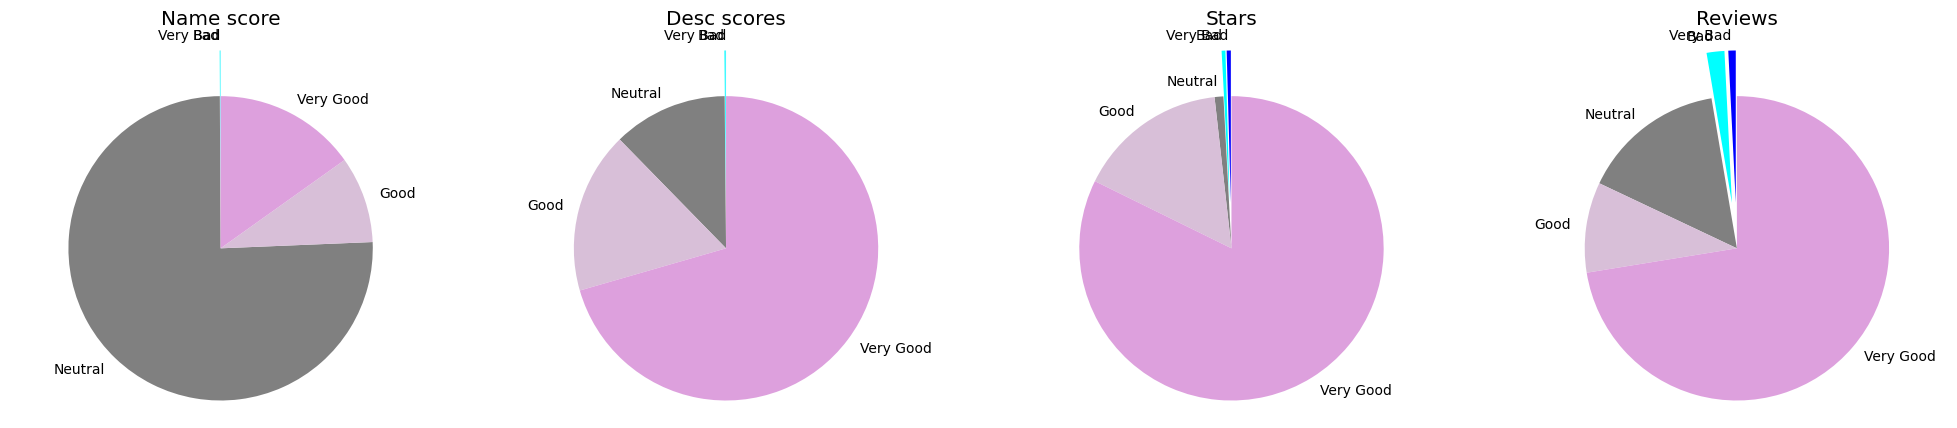

In [ ]:
# read NYtrans6.csv in f_csv.rar to get all data
df=pd.read_csv(r'C:\Users\georg\Desktop\jupyterlab\DTU\CT4DS\fproject\NYtrans6.csv')
# read NYtransREVnSCALE3.csv in f_csv.rar to get data
dg=pd.read_csv(r'C:\Users\georg\Desktop\jupyterlab\DTU\CT4DS\fproject\NYtransREVnSCALE3.csv')

print(min(len(df),len(dg)))

# take the scaled scores 

name=list(df['n_num_scaled'])
#print(len(name))
#df['n_num_scaled'].value_counts().sort_index()

desc=list(df['d_num_scaled'])
#print(len(desc))
#df['d_num_scaled'].value_counts().sort_index()

# stars are the apartments review scores 
star=list(df['review_scores_rating_int'])
#print(len(star))
#df['review_scores_rating_int'].value_counts().sort_index()

# take all the reviews
rev=list(dg['num_scaled'])
# sort them in order to include the lowest points
rev.sort()
# take the number equal to len(df)
rev=rev[:len(df)]
#print(len(rev))
counter = collections.Counter(rev)
#print(counter)

# extract frequency of scores
f=collections.Counter(name)
fname=[f[x] for x in sorted(f.keys())]
f=collections.Counter(desc)
fdesc=[f[x] for x in sorted(f.keys())]
f=collections.Counter(star)
fstar=[f[x] for x in sorted(f.keys())]
frev=[counter[x] for x in sorted(counter.keys())]

# take data percentage

pname=[round((i*100)/sum(fname),3) for i in fname]
pdesc=[round((i*100)/sum(fdesc),3) for i in fdesc]
pstar=[round((i*100)/sum(fstar),3) for i in fstar]
prev=[round((i*100)/sum(frev),3) for i in frev]

# pie chart

# Data for the pie charts
labels1 = ['Very Bad', 'Bad', 'Neutral', 'Good', 'Very Good']

# Create subplots
fig, axs = plt.subplots(1, 4, figsize=(25, 5))
expl=(0.3,0.3,0,0,0)
cl=('blue','cyan','grey','Thistle', 'Plum')

# First pie chart
#axs[0].pie(pname,colors=cl, explode=expl,labels=labels1, autopct='%1.1f%%', startangle=90)
axs[0].pie(pname,colors=cl, explode=expl,labels=labels1, startangle=90)

#patches, texts, auto = axs[0].pie(pname, colors=cl, shadow=True, startangle=90,explode=expl, autopct='%1.1f%%' )
#patches, texts, auto = axs[0].pie(pname,colors=cl, explode=expl,labels=labels1, startangle=90)
#axs[0].legend(patches, labels1, loc="best")

axs[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axs[0].set_title('Name score')

# Second pie chart
#axs[1].pie(pdesc,colors=cl, explode=expl,labels=labels1, autopct='%1.1f%%', startangle=90)
axs[1].pie(pdesc,colors=cl, explode=expl,labels=labels1, startangle=90)
axs[1].axis('equal')
axs[1].set_title('Desc scores')

# Third pie chart
#axs[2].pie(pstar,colors=cl, explode=expl,labels=labels1, autopct='%1.1f%%', startangle=90)
axs[2].pie(pstar,colors=cl, explode=expl,labels=labels1, startangle=90)
axs[2].axis('equal')
axs[2].set_title('Stars')

# Third pie chart
#axs[3].pie(prev,colors=cl, explode=expl,labels=labels1, autopct='%1.1f%%', startangle=90)
axs[3].pie(prev,colors=cl, explode=expl,labels=labels1, startangle=90)
axs[3].axis('equal')
axs[3].set_title('Reviews')

# Display the pie charts
plt.show()

